## 根据简单指标构建趋势，然后验证指数向趋势方向运行的概率（做多）

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#df = pd.read_csv(r'E:\workspace\qqqhhh\data\rb\zl.csv')  # 螺纹主连日线
#df = pd.read_csv(r'E:\workspace\qqqhhh\data\rb\zlh.csv') # 螺纹主连小时线
#df = pd.read_csv(r'E:\workspace\qqqhhh\data\rb\zs.csv')  # 螺纹指数日线
#df = pd.read_csv(r'E:\workspace\qqqhhh\data\rb\zsh.csv') # 螺纹指数小时线

#构建指标
def get_DKX(df, n=10):
    df['a'] = (df.c * 3 + df.l + df.o + df.h)/6
    df['b'] = (20*df.a + 19*df.a.shift(1) + 18*df.a.shift(2) + 17*df.a.shift(3) + 
        16*df.a.shift(4) + 15*df.a.shift(5) + 14*df.a.shift(6) + 
        13*df.a.shift(7) + 12*df.a.shift(8) + 11*df.a.shift(9) + 
        10*df.a.shift(10) + 9*df.a.shift(11) + 8*df.a.shift(12) + 7*df.a.shift(13) + 
        6*df.a.shift(14) + 5*df.a.shift(15) + 4*df.a.shift(16) + 
        3*df.a.shift(17) + 2*df.a.shift(18) + 1*df.a.shift(19))/210
    df['d'] = df.b.rolling(n).mean()
    return df.drop(['a'], axis=1)



# 显示结果的函数
def result(df):
    '''df is dataframe'''
    df['c_up'] = np.where( df.c > df.c.shift(1), 1, 0 )
    gailv = np.round(df.c_up.sum()/df.shape[0], 3) * 100
    gailv = str(gailv)[:4]
    #print( '收盘价比前一天收盘价高的概率 {}% '.format(gailv)) # 某条件下   c比前一天高的概率
    
    df['l_up'] = np.where( df.l > df.l.shift(1), 1, 0 )
    gailv2 = round(df.l_up.sum()/df.shape[0], 3) * 100
    gailv2 = str(gailv2)[:4]
    #print('最低价比前一天最低价高的概率 {}%'.format(gailv2)) # 某条件下   low比前一天高的概率
    return gailv, gailv2

def ready(whichdata):
    df = pd.read_csv(r'E:\workspace\qqqhhh\data\rb\{}.csv'.format(whichdata))
    df = get_DKX(df) 
    df['ma'] = df.c.rolling(window=10, center=False).mean()
    return df.copy()

columns = ['主连日线','主连小时线','指数日线','指数小时线']
# 前4个同向的概率，后4个反向
index = ['DKXb向上','K线高于DKXb','ma向上','K线高于ma','DKXb向下','K线低于DKXb','ma向下','K线低于ma']
# 收盘价各种情况比较
dfc = pd.DataFrame(index=index, columns=columns)
# 最低价各种情况比较
dfl = pd.DataFrame(index=index, columns=columns)

def process(data, column):
    # 过滤出DKX 的b线 向上的数据
    df = ready(data)
    df['contidion'] = np.where(df.b > df.b.shift(1), 1, 0)
    df = df.loc[df.contidion==1,:]
    c1,l1 = result(df)
    
    # 过滤出DKX 的b线 向下的数据
    df = ready(data)
    df['contidion'] = np.where(df.b < df.b.shift(1), 1, 0)
    df = df.loc[df.contidion==1,:]
    c1b,l1b = result(df)
    
    # 过滤出k线比DKX b线 高的数据
    df = ready(data)
    df['contidion'] = np.where(df.l > df.b, 1, 0)
    df = df.loc[df.contidion==1,:]
    c2,l2 = result(df)
    
    # 过滤出k线比DKX b线 低的数据
    df = ready(data)
    df['contidion'] = np.where(df.h < df.b, 1, 0)
    df = df.loc[df.contidion==1,:]
    c2b,l2b = result(df)
    
    # 过滤出ma向上的数据
    df = ready(data)
    df['contidion'] = np.where(df.ma > df.ma.shift(1), 1, 0)
    df = df.loc[df.contidion==1, :]
    c3,l3 = result(df)
    
    # 过滤出ma向下的数据
    df = ready(data)
    df['contidion'] = np.where(df.ma < df.ma.shift(1), 1, 0)
    df = df.loc[df.contidion==1, :]
    c3b,l3b = result(df)
    
    # k线在ma上的数据
    df = ready(data)
    df['contidion'] = np.where(df.l > df.ma, 1, 0)
    df = df.loc[df.contidion==1, :]
    c4,l4 = result(df)
    
    # k线在ma下的数据
    df = ready(data)
    df['contidion'] = np.where(df.h < df.ma, 1, 0)
    df = df.loc[df.contidion==1, :]
    c4b,l4b = result(df)
    
    dfc[column] = [c1,c2,c3,c4,c1b,c2b,c3b,c4b]
    dfl[column] = [l1,l2,l3,l4,l1b,l2b,l3b,l4b]
    #print(dfc)
    

In [2]:
process('zl', '主连日线')
process('zlh', '主连小时线')
process('zs', '指数日线')
process('zsh', '指数小时线')

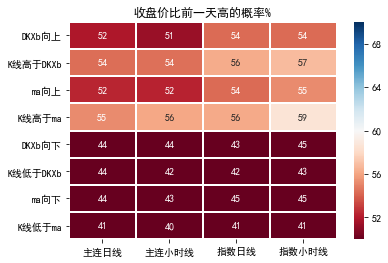

In [3]:
plt.rcParams['font.sans-serif'] = ['SimHei'] 
plt.title('收盘价比前一天高的概率%')
dfc = dfc.astype(float)
ax = sns.heatmap(dfc, center=60, linewidths=1, 
                 cmap="RdBu", vmin=50, vmax=70, annot=True)
ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=0)
ax.set_yticklabels(ax.yaxis.get_majorticklabels(), rotation=0)
plt.show()

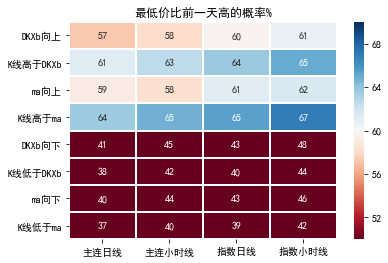

In [4]:
plt.rcParams['font.sans-serif'] = ['SimHei'] 
plt.title('最低价比前一天高的概率%')
dfl = dfl.astype(float)
ax = sns.heatmap(dfl, center=60, linewidths=1, 
                 cmap="RdBu", vmin=50, vmax=70, annot=True)
ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=0)
ax.set_yticklabels(ax.yaxis.get_majorticklabels(), rotation=0)
plt.show()